In [1]:
import poppy
import jax

In [2]:
poppy.POLYNOMIAL[3329][4]=[3323,2345,1603,800,1]
poppy.POLYNOMIAL[3329][5]=[2801,3247,697,1403,2111,1]

In [3]:
# FINITE FIELD LATTICE BASED KEY ENCAPSULATION.
p = 3329 # is the field characteristic.
n = 4 # is the field degree. {4,5}
f = poppy.field(p,n) # is the finite field.
N = 4 # is the number of bits in in a word.
k = 16 # is the square root of the number of words in the message. {4,8,16}
b = 1 # is the number of k*k word messages.
psd = poppy.SEED # is the public seed.
ssd = (908235,3209,4580,1,583981) # are secret seeds.
M = jax.numpy.tile(jax.numpy.arange(k*k, dtype = jax.numpy.uint8),b).reshape((b,k,k))%(2**N) # is the message.

In [4]:
def uniform(seed):
  sample = jax.random.randint(jax.random.key(seed), (b,k,k,n), 0,f.p, dtype = poppy.DTYPE)
  return sample
def normal(seed):
  bits = jax.random.bits(jax.random.key(seed), shape = (b*k*k*n,1), dtype = jax.numpy.uint8)
  bitsream = jax.numpy.unpackbits(bits, axis = 1).reshape((b*k*k*n,2,4))
  sample = jax.numpy.sum(bitsream, axis = 2, dtype = poppy.DTYPE)
  sample = jax.numpy.subtract(sample[:,0],sample[:,1]).reshape((b,k,k,n))%f.p
  return sample
def rep(a,b):
  return poppy.rep(a,b,p)
def matmul(a,b):
  return poppy.matmul55(a,b,p)
def outer(a,b):  
  return poppy.outer33(a,b,p)
def compress(a):
  return jax.numpy.astype(a,jax.numpy.uint16)
def decompress(a):
  return jax.numpy.astype(a,poppy.DTYPE)
def encode(m):
  return (jax.numpy.rint((f.p/(2**N))*m.reshape((b,k,k,1,1))))*(f.DUAL[0].reshape((1,1,1,n,n)))%f.p
def decode(mu):
  return jax.numpy.astype(jax.numpy.rint((2**N)/f.p*poppy.trace(mu,f.p))%(2**N), jax.numpy.uint8).reshape((b,k,k))

@jax.jit
def keygen():
  sk = rep(normal(ssd[0]),f.DUAL.swapaxes(1,2)) # b k k n n secret key.
  e1 = rep(normal(ssd[1]),f.BASIS)              # b k k n n error.
  pk1 = rep(uniform(psd), f.DUAL)               # b k k n n public key.
  pk2 = (matmul(pk1,sk)+e1)%f.p                 # b k k n n public key.
  ek = (compress(pk2),psd) # Encapsulation key.
  dk = compress(sk)        # Decapsulation key.
  return sk,e1,pk1,pk2, ek,dk

@jax.jit
def encrypt(m,ek):
  pk2,psd = ek
  pk1 = rep(uniform(psd), f.DUAL)                # b k k n n public key.
  r = rep(normal(ssd[2]), f.DUAL)                # b k k n n randomness.
  e2 = rep(normal(ssd[3]),f.BASIS.swapaxes(1,2)) # b k k n n error.
  e3 = rep(normal(ssd[4]),f.DUAL)                # b k k n n error.
  pk3 = (matmul(r,pk1)+e2)%f.p                   # b k k n n public key.
  mu = encode(m)                                 # b k k n n message.
  ct = (matmul(r,decompress(pk2))+mu+e3)%f.p     # b k k n n cipher text.
  c = (compress(pk3),compress(ct)) # Ciphertext.
  return r,e2,e3,pk3,mu,ct, c

@jax.jit
def decrypt(c,dk):
  pk3,ct = c
  mu = (decompress(ct)-matmul(decompress(pk3),decompress(dk)))%f.p
  m = decode(mu)
  return mu, m

In [5]:
sk,e1,pk1,pk2, ek,dk = keygen()
r,e2,e3,pk3,MU,ct, c = encrypt(M,ek)
mu, m = decrypt(c,dk)

print(f'\nFIRST {M.shape[1]}x{M.shape[2]} WORD MESSAGE:')
print(M[0])
print('\nDECRYPTION ERROR:')
print((M-m)[0])


FIRST 16x16 WORD MESSAGE:
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]]

DECRYPTION ERROR:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

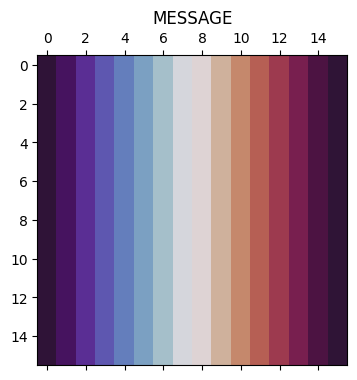

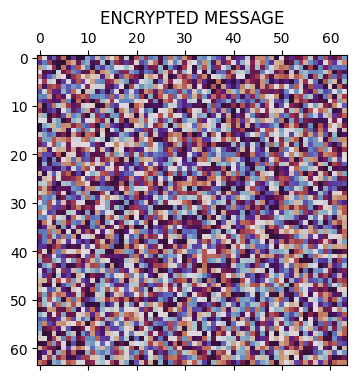

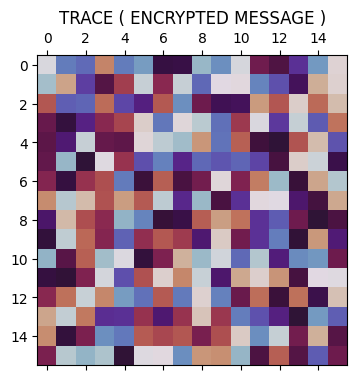

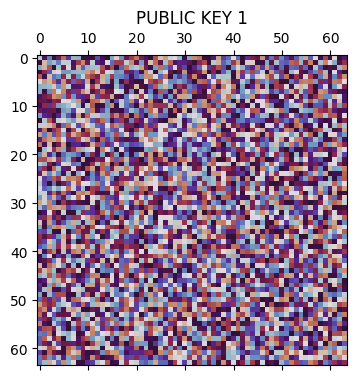

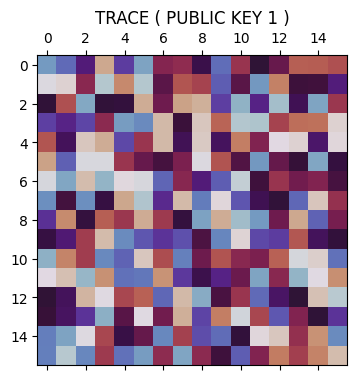

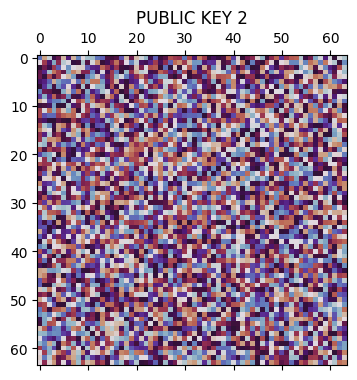

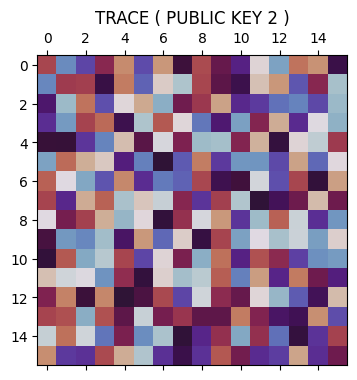

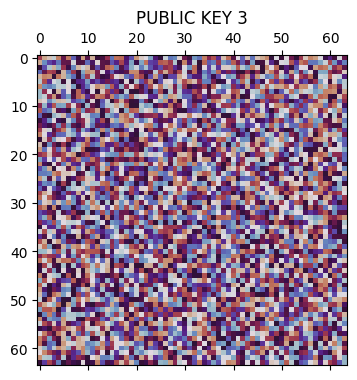

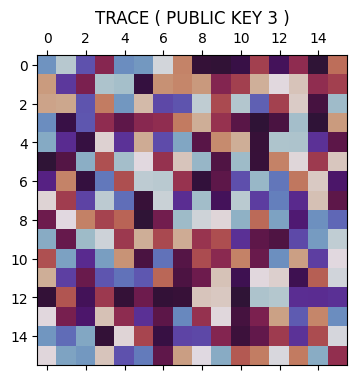

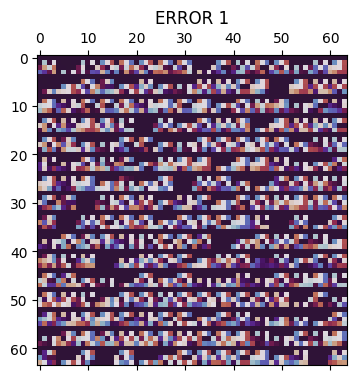

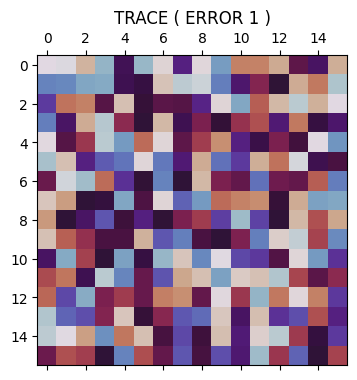

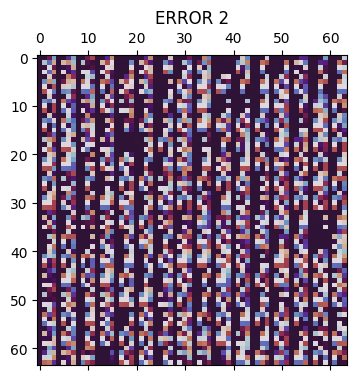

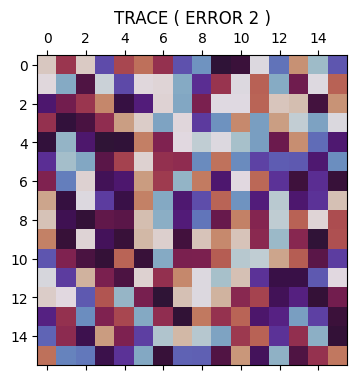

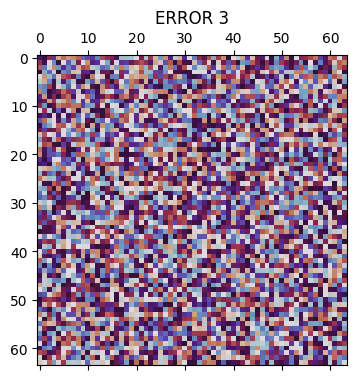

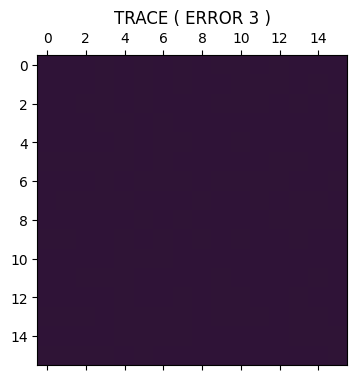

In [6]:
poppy.plot(poppy.trace(MU,p).reshape((-1,k)), title = 'MESSAGE')
poppy.plot(ct.swapaxes(2,3).reshape((-1,k*n)), title = 'ENCRYPTED MESSAGE')
poppy.plot(poppy.trace(ct,p).reshape((-1,k)), title = 'TRACE ( ENCRYPTED MESSAGE )')
poppy.plot(pk1.swapaxes(2,3).reshape((-1,k*n)), title = 'PUBLIC KEY 1')
poppy.plot(poppy.trace(pk1,p).reshape((-1,k)), title = 'TRACE ( PUBLIC KEY 1 )')
poppy.plot(pk2.swapaxes(2,3).reshape((-1,k*n)), title = 'PUBLIC KEY 2')
poppy.plot(poppy.trace(pk2,p).reshape((-1,k)), title = 'TRACE ( PUBLIC KEY 2 )')
poppy.plot(pk3.swapaxes(2,3).reshape((-1,k*n)), title = 'PUBLIC KEY 3')
poppy.plot(poppy.trace(pk3,p).reshape((-1,k)), title = 'TRACE ( PUBLIC KEY 3 )')
poppy.plot(e1.swapaxes(2,3).reshape((-1,k*n)), title = 'ERROR 1')
poppy.plot(poppy.trace(e1,p).reshape((-1,k)), title = 'TRACE ( ERROR 1 )')
poppy.plot(e2.swapaxes(2,3).reshape((-1,k*n)), title = 'ERROR 2')
poppy.plot(poppy.trace(e2,p).reshape((-1,k)), title = 'TRACE ( ERROR 2 )')
poppy.plot(e3.swapaxes(2,3).reshape((-1,k*n)), title = 'ERROR 3')
poppy.plot(poppy.trace(e3,p).reshape((-1,k)), title = 'TRACE ( ERROR 3 )')

In [7]:
print(f'\nTRACE POWER BASIS\n{poppy.trace(f.BASIS,p)}')
print(f'\nTRACE DUAL BASIS\n{poppy.trace(f.DUAL,p)}')
print(f'\nTRACE ( POWER x DUAL )\n{poppy.trace(outer(f.BASIS,f.DUAL),p)}')


TRACE POWER BASIS
[   4 2529  955 2028]

TRACE DUAL BASIS
[1 0 0 0]

TRACE ( POWER x DUAL )
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


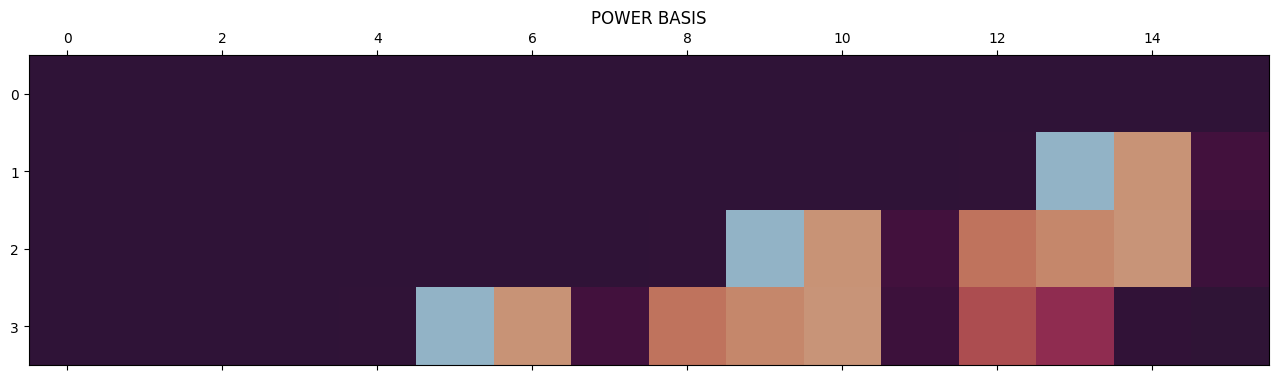

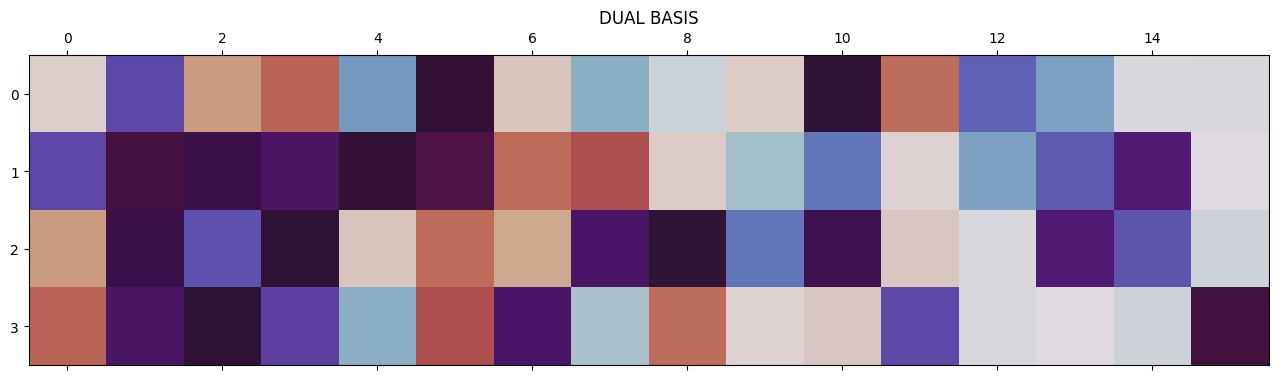

In [8]:
poppy.plot(f.BASIS, title = 'POWER BASIS')
poppy.plot(f.DUAL, title = 'DUAL BASIS')

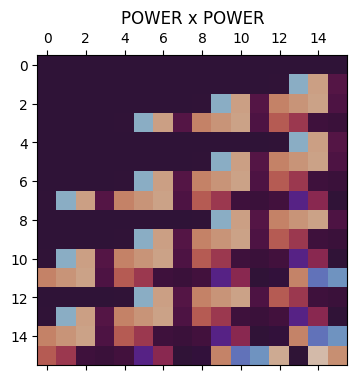

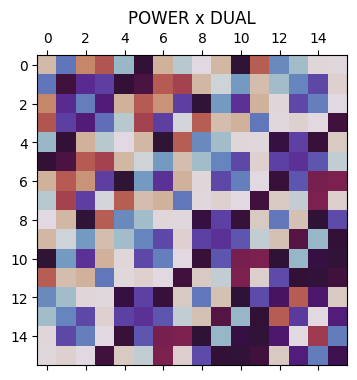

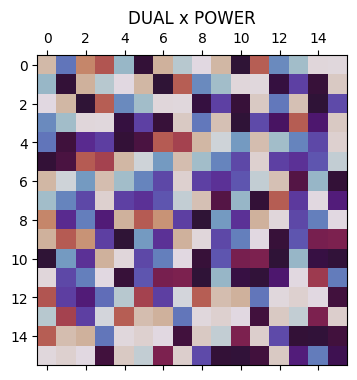

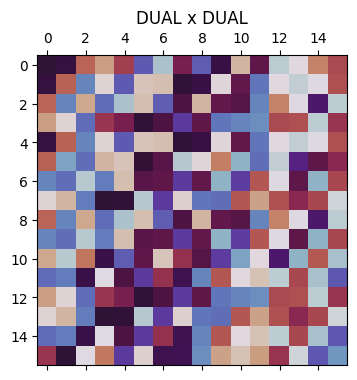

In [9]:
poppy.plot(outer(f.BASIS,f.BASIS).reshape((n*n,n*n)), title = 'POWER x POWER')
poppy.plot(outer(f.BASIS,f.DUAL).reshape((n*n,n*n)), title = 'POWER x DUAL')
poppy.plot(outer(f.DUAL,f.BASIS).reshape((n*n,n*n)), title = 'DUAL x POWER')
poppy.plot(outer(f.DUAL,f.DUAL).reshape((n*n,n*n)), title = 'DUAL x DUAL')

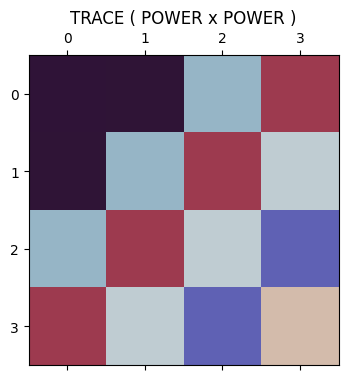

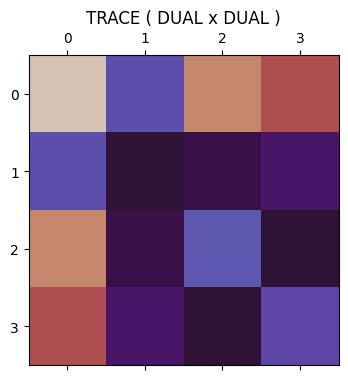

In [10]:
poppy.plot(poppy.trace(outer(f.BASIS,f.BASIS),p), title = 'TRACE ( POWER x POWER )')
poppy.plot(poppy.trace(outer(f.DUAL,f.DUAL),p), title = 'TRACE ( DUAL x DUAL )')